In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.impute import SimpleImputer

df = pd.read_pickle('treino.pkl.gz')

In [2]:
def tree_thresholds(dataframe, series_name, target, n):
    mdl = DecisionTreeClassifier(random_state = 42, max_depth = n)
    mdl.fit(dataframe[[series_name]], dataframe[[target]])
    plt.style.use('default')
    fig = plt.figure(figsize = (12, 5))
    _ = tree.plot_tree(mdl)
    plt.show()
    
def discretize_proba(x, thresh):
    for n in range(len(thresh)):
        if x == thresh[n]:
            return n + 1
        
def proba_box(dataframe, series_name, target, n):
    disc = DecisionTreeClassifier(max_depth = n, random_state = 42)
    disc.fit(dataframe[[series_name]], dataframe[[target]])
    new_name = series_name + '_proba'
    dataframe[new_name] = disc.predict_proba(dataframe[[series_name]])[:, 1] 
    thresh = dataframe[new_name].unique().tolist()
    thresh.sort()

    dataframe[new_name] = dataframe[new_name].apply(lambda x: discretize_proba(x, thresh)) 

    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (11, 5)
    sns.boxplot(dataframe[new_name], dataframe[series_name])
    plt.show()
    
def quali_var_indep_hyp_test(dataframe, series_name, target, alpha):
    stat, pval, dof, exp = chi2_contingency(pd.crosstab(dataframe[series_name], dataframe[target]))
    crit = chi2.ppf(q = (1 - alpha), df = dof)
    if stat >= crit:
        cramer = np.sqrt( ( stat ) / sum(sum(exp)) * (min(exp.shape) - 1) )
    else:
        cramer = None
    return stat, crit, cramer

def year_to_age(x):
    if x == '00':
        return 20
    else:
        return (100 - int(x)) + 20

In [3]:
# seleção preliminar de features:
# o critério desta foi: lógica / explicabilidade, as features eliminadas são consideradas como não relacionadas
# à probabilidade de 'deafult' ou não

sub1 = ['id_pessoa', 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo', 'nascimento', 'emprego', 'score', 
        'score_desc']
sub2 = ['tem_med_emp', 'tem_pri_emp']
sub4 = ['pri_qtd_tot_emp', 'pri_qtd_tot_emp_atv', 'pri_qtd_tot_def', 'pri_emp_abt', 'pri_emp_san','pri_emp_tom']

# sub1_dropd = ['agencia', 'revendedora', 'montadora', 'Current_pincode_ID', 'data_contrato', 'estado', 
#               'funcionario']
# sub2_dropd = ['par_pri_emp', 'par_seg_emp', 'nov_emp_6m', 'def_emp_6m', 'qtd_sol_emp']
# sub3 = ['flag_telefone', 'flag_aadhar', 'flag_pan', 'flag_eleitor', 'flag_cmotorista', 'flag_passaporte']
# sub5 = ['sec_qtd_tot_emp', 'sec_qtd_tot_emp_atv', 'sec_qtd_tot_def', 'sec_emp_abt', 'sec_emp_san',
#          'sec_emp_tom']

# --------------------
# darei início à análise com as features: 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo'
# suponho que estas possuam correlção entre si, sendo assim, cogito resumi-las em apenas uma variável, 
# a presença de diversas features contendo informações sobre um mesmo aspecto acaba por atribuir um peso maior
# ao mesmo, além disso, não traz informações úteis e nos sujeitamos à maldição da dimensionalidade 

# 1. ao consultando a metadata:
# valor_emprestimo -> Valor total emprestado pela financeira
# custo_ativo -> Custo do ativo(veículo)
# emprestimo_custo -> Razão entre valor emprestado e valor do ativo(veículo)

# já 'por definição', conclui-se que emprestimo custo estará altamente correlacionada a uma combinação entre
# 'valor_emprestimo' e 'custo_ativo', que por sua vez, também possuem correlação entre si

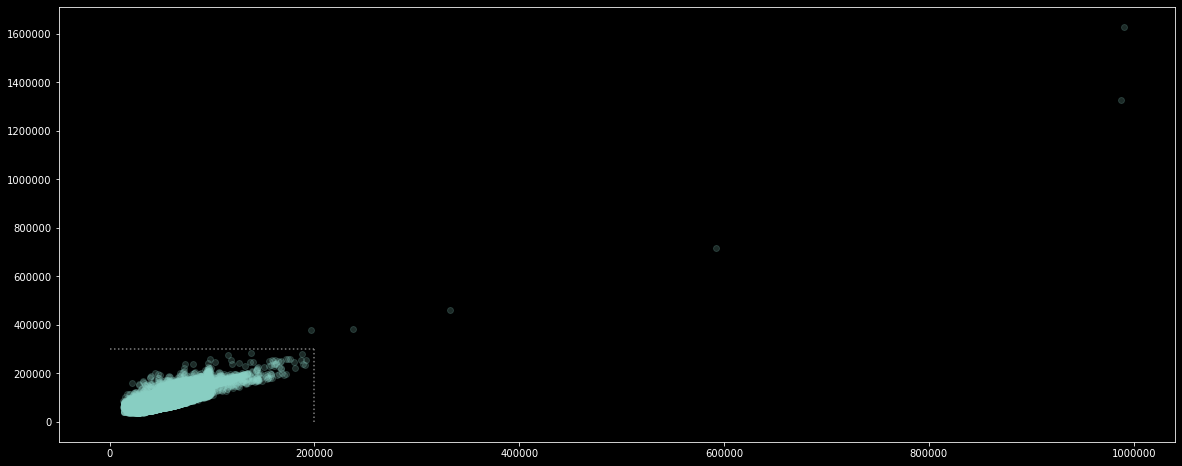

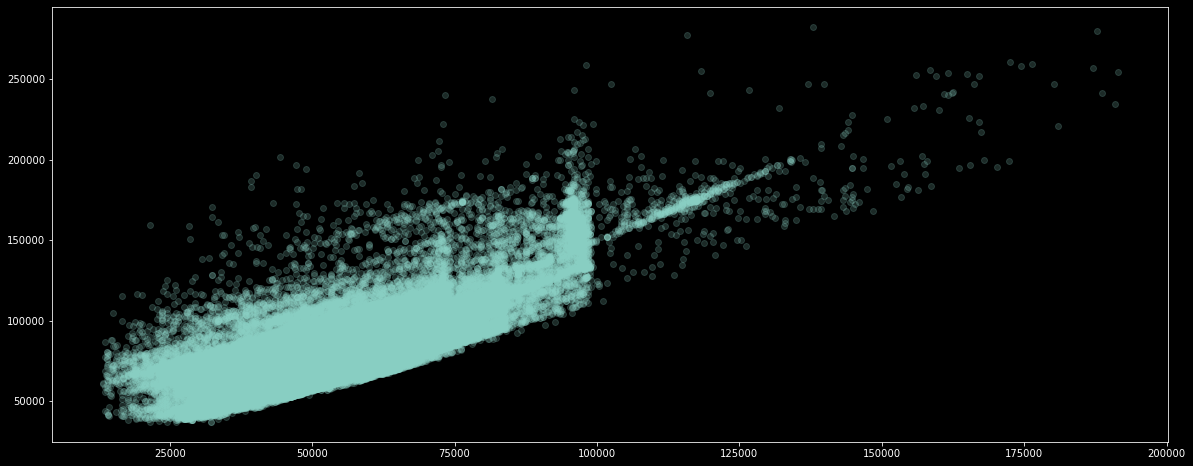

In [4]:
# ao observar o gráfico de dispersão entre as variáveis, percebemos a necessidade de eliminar outliers
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (20, 8)
plt.scatter(df['valor_emprestimo'], df['custo_ativo'], alpha = 0.2)
plt.plot([0, 200000], [300000, 300000], color = 'grey', ls = ':')
plt.plot([200000, 200000], [0, 300000], color = 'grey', ls = ':')
plt.show()

vl_cst_no_otlr = df.loc[(df['valor_emprestimo'] <= 200000) & (df['custo_ativo'] <= 300000)]
plt.scatter(vl_cst_no_otlr['valor_emprestimo'], vl_cst_no_otlr['custo_ativo'], alpha = 0.2)
plt.show()

In [6]:
# precisa rodar duas vezes, r = 0.7387544522220792
print('r:', pearsonr(vl_cst_no_otlr['valor_emprestimo'], vl_cst_no_otlr['custo_ativo']))

# que porcentagem dos dados foi eliminada ?
p = round(1 - len(vl_cst_no_otlr) / len(df), 5)
n = len(df) - len(vl_cst_no_otlr)
print(f'porcentagem: {p} %\ntotal: {n}')
# estamos dispostos a aceitar esta perda de observações ? sim

r: (0.7387544522220792, 0.0)
porcentagem: 3e-05 %
total: 6


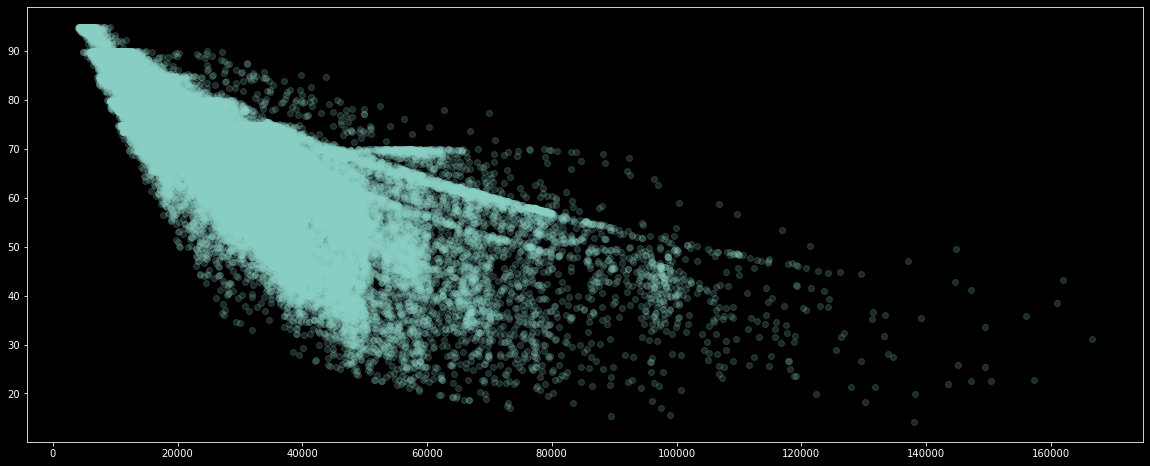

(-0.8504400557607774, 0.0)


In [7]:
# eliminando de fato, os outliers, de acordo com 'valor_emprestimo' e 'custo_ativo'
df = df.loc[(df['valor_emprestimo'] <= 200000) & (df['custo_ativo'] <= 300000)]

# combinando 'valor_emprestimo' e 'custo_ativo'
df['dif_val_custo'] = df['custo_ativo'] - df['valor_emprestimo'] 

# agora nos restam as features 'dif_val_custo' e 'emprestimo_custo', que plotadas em um gráfico de dispersão, 

plt.scatter(df['dif_val_custo'], df['emprestimo_custo'], alpha = 0.2)
plt.show()

print(pearsonr(df['dif_val_custo'], df['emprestimo_custo']))

# não sei como cominar estas duas features, posto que uma consiste em uma proporção, e outra em um valor
# 'inteiro', então, avaliarei a importância de uma contra a outra, discrertizando-as com árvores de decisão, 
# em seguida, plotando as taxas de 'default' para cada uma e julgando qual ordena o mesmo com maior eficácia

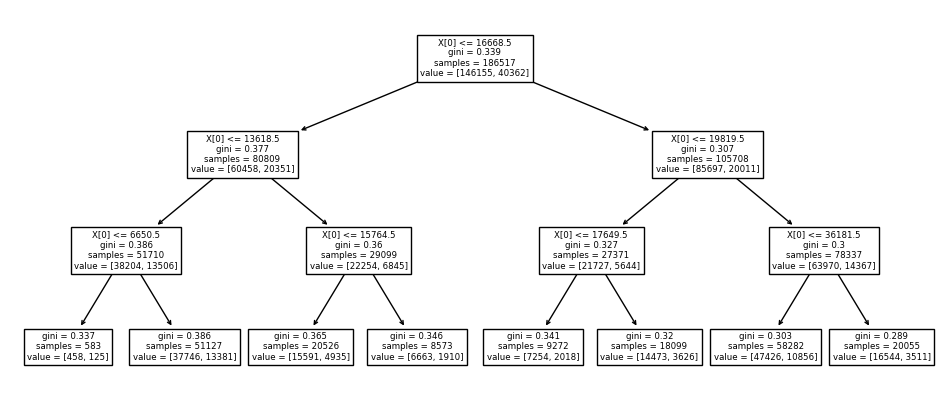

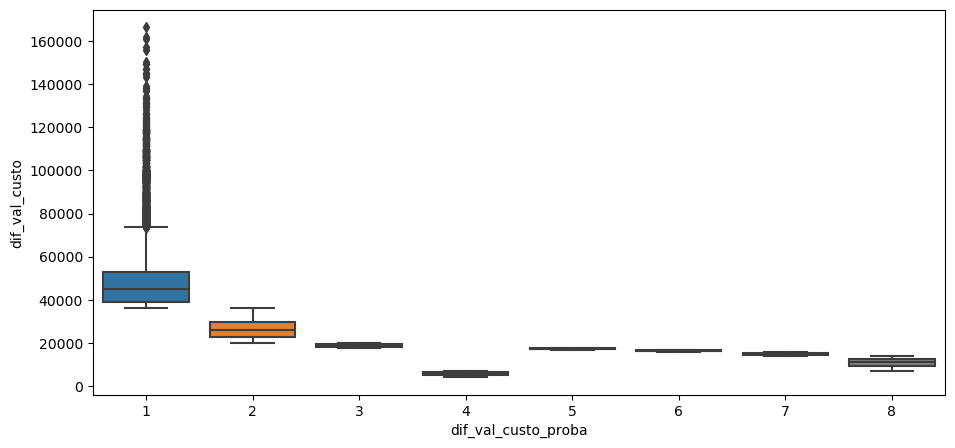

In [8]:
tree_thresholds(df, 'dif_val_custo', 'default', 3)
proba_box(df, 'dif_val_custo', 'default', 3)

In [9]:
# conforme o 'dif_tree' cresce, maior a probabilidade de 'default', as ordenadas contém a variável quantitativa
# 'dif_val_custo'; percebe-se, ao observar o boxplot, que a probabilidade de 'default' não aumenta ou diminui
# respeitando o valor de 'dif_val_custo'

# os valores mais baixos de 'dif_val_custo' não correspondem aos valore mais baixos ou mais altos de
# probabiliade de 'default'

# na próxima célula, realizo o mesmo processo em 'emprestimo_custo'

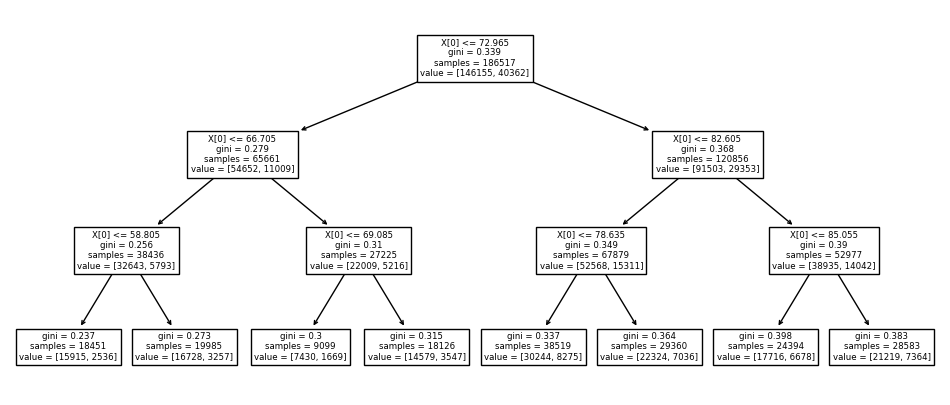

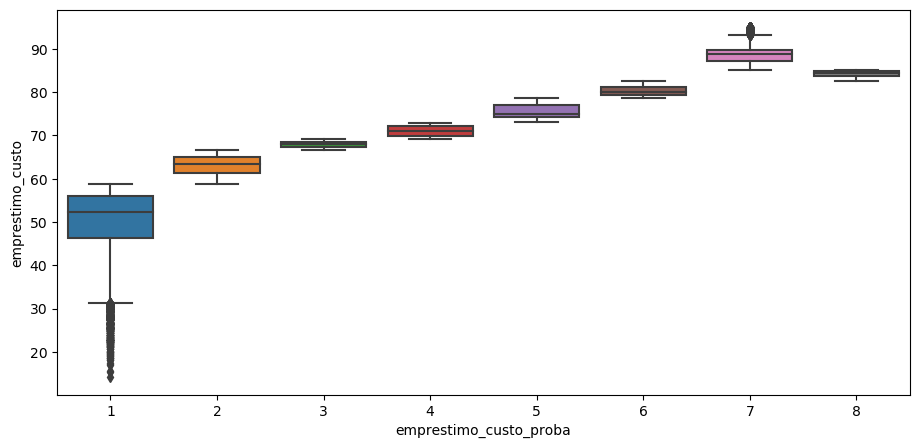

In [10]:
tree_thresholds(df, 'emprestimo_custo', 'default', 3)
proba_box(df, 'emprestimo_custo', 'default', 3)

In [11]:
# no caso de 'emprestimo_custo', percebe-se que existe uma correlação significativa com a probabilidade de 
# 'default', com exceção de uma inconsistência quando a probabilidade de 'default' é a mais alta

# se utilizarmos menos bins, acredito que essa diferença desapareceria

# conclusão da análise de 'valor_emprestimo', 'custo_ativo', 'emprestimo_custo':
# talvez possamos usar a variável 'emprestimo_custo'

In [12]:
# em seguida, faço a análise e transformação de 'nascimento'

# possíveis anos de nascimento
# suponho que todos sejam '19--', com exceção de '1900', neste caso, considero que o ano seja '2000'
df['nascimento'].str[6:].unique()

array(['76', '97', '83', '94', '92', '80', '79', '95', '96', '72', '73',
       '71', '88', '84', '61', '70', '75', '85', '69', '77', '67', '82',
       '74', '89', '63', '64', '87', '65', '91', '81', '90', '78', '86',
       '93', '99', '68', '62', '98', '55', '58', '59', '66', '00', '60',
       '56', '54', '57', '49'], dtype=object)

In [13]:
df['nascimento'] = df['nascimento'].str[6:].apply(lambda x: year_to_age(x))
df = df.rename(columns = {'nascimento': 'idade'})

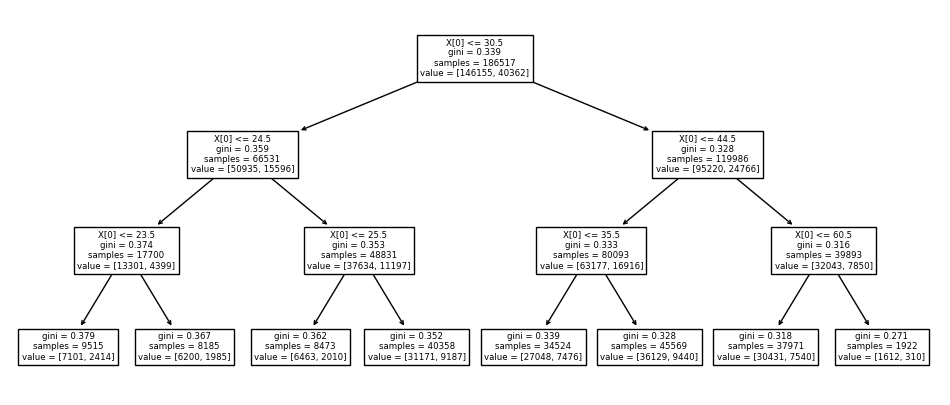

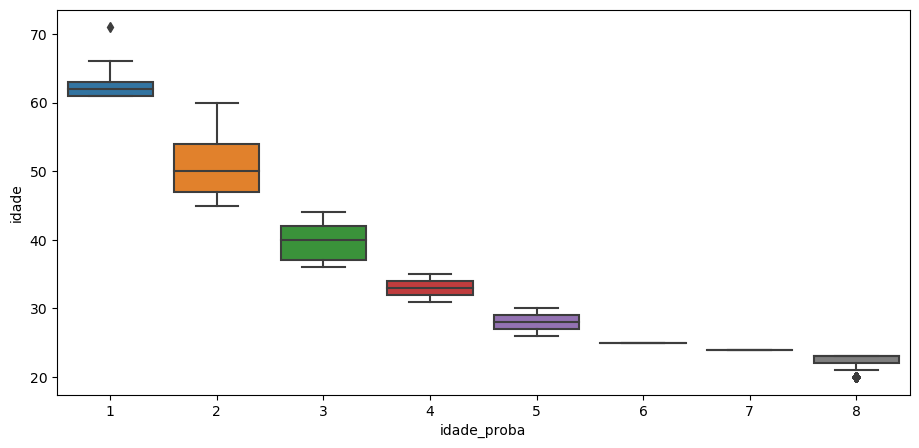

In [14]:
tree_thresholds(df, 'idade', 'default', 3)
proba_box(df, 'idade', 'default', 3)

In [15]:
# conclusão da análise de idade:
# por mais que exista a possibilidade de gerar controvérsias, a variável idade ordena o 'default' de forma 
# consistente

In [16]:
# em seguida, faço a análise da variável emprego

print(df['emprego'].isnull().value_counts())

df['emprego'].unique()

# será necessário imputar alguns valores

False    180371
True       6146
Name: emprego, dtype: int64


array(['Salaried', 'Self employed', nan], dtype=object)

In [17]:
imp = SimpleImputer(strategy = 'constant', fill_value = 'Unknown')
df['emprego'] = imp.fit_transform(df[['emprego']])
df['emprego'] = df['emprego'].str.replace(' ', '_')

In [18]:
# como se trata de uma variável qualitativa não ordinal, repetirei o processo das variáveis anteriores
# em vez disso, opto por realizar teste qui-quadrado, caso este acuse dependência, é realizado cramer V, 
# mensurando a força da mesma

stat, crit, cramer = quali_var_indep_hyp_test(df, 'emprego', 'default', 0.01)
print(round(stat, 2))
print(round(crit, 2))

145.41
9.21


In [19]:
# Com uma estatística qui-quadrada de 145.41, e um valor crítico de 9.21, falhamos em rejeitar a hipótese nula
# de independência, todavia, para quantificarmos a associação entre 'emprego' e 'default', consultamos
# Cramér's V, assim, sabemos se vale a pena manter esta variável no modelo
round(cramer, 3)

0.028

In [20]:
# conclusão da análise de emprego:
# associação insignificante

In [21]:
# em seguida, análise de 'score' e 'score_desc'

# suponho que seria seguro supor que estas variáveis trazem informações redundantes, entretanto, segue a
# análise destas, a fim de garantir que não perderemos informação, ao eliminar uma delas

In [22]:
df['score_desc'].value_counts(1)

No Bureau History Available                                0.502351
C-Very Low Risk                                            0.068830
A-Very Low Risk                                            0.060466
D-Very Low Risk                                            0.048752
B-Very Low Risk                                            0.039294
M-Very High Risk                                           0.037873
F-Low Risk                                                 0.036710
K-High Risk                                                0.035203
H-Medium Risk                                              0.029214
E-Low Risk                                                 0.024813
I-Medium Risk                                              0.023338
G-Low Risk                                                 0.017162
J-High Risk                                                0.016106
Not Scored: Sufficient History Not Available               0.016084
Not Scored: Not Enough Info available on the cus

In [23]:
# em um primeiro momento, de forma grosseira, considero a possibilidade de dividir os possíveis valores de 
# 'score_desc' entre possuindo a palavra 'Risk' ou se iniciar com 'No'

In [24]:
df.loc[df['score_desc'].str.contains('No'), 'score_desc'].unique().tolist()

['No Bureau History Available',
 'Not Scored: Only a Guarantor',
 'Not Scored: No Updates available in last 36 months',
 'Not Scored: No Activity seen on the customer (Inactive)',
 'Not Scored: Sufficient History Not Available',
 'Not Scored: Not Enough Info available on the customer',
 'Not Scored: More than 50 active Accounts found']

In [25]:
df.loc[(df['score_desc'].str.contains('Risk')) | (df['score_desc'].str.contains('Risk')), 
       'score_desc'].unique().tolist()

['F-Low Risk',
 'A-Very Low Risk',
 'C-Very Low Risk',
 'H-Medium Risk',
 'M-Very High Risk',
 'K-High Risk',
 'B-Very Low Risk',
 'I-Medium Risk',
 'D-Very Low Risk',
 'E-Low Risk',
 'J-High Risk',
 'G-Low Risk',
 'L-Very High Risk']

In [26]:
# à partir deste ponto, considero dois tipos de 'score_desc', os que contém 'Risk' e os que contém 'No'

valor máximo: 18


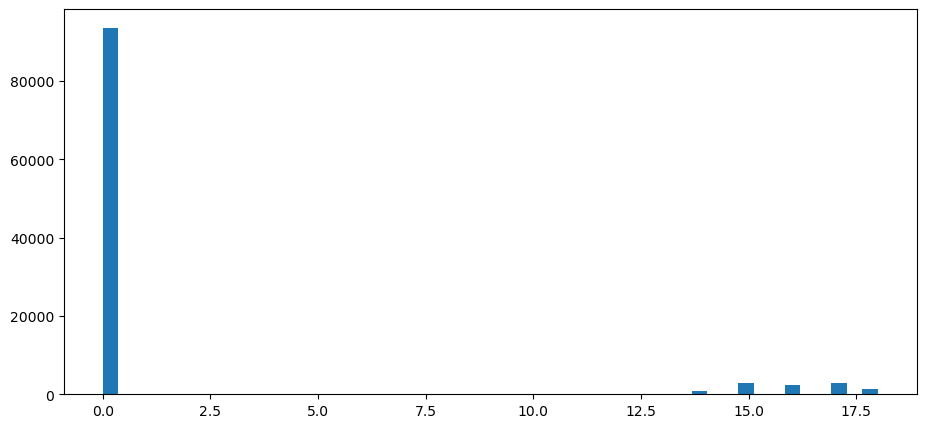

In [27]:
# como se comporta o 'score', em dados que possuem 'No' em 'score_desc' ?

# como é o score de dados nestes grupos ?
no_score = df.loc[df['score_desc'].str.contains('No'), 'score_desc'].unique().tolist()
no_score_score_series = df.loc[df['score_desc'].isin(no_score), 'score']
print('valor máximo:', no_score_score_series.max())
plt.hist(no_score_score_series, bins = 50)
plt.show()

In [28]:
# dados que possuem 'No' em seus 'score_desc' consistem principalmente em zeros, chegando a, no máximo, 18, 
# não farei a discretização dos dados decidindo os limiares por conta própria, mas consigo imaginar que 
# poderíamos alocar todos os dados contendo 'No' em 'score_desc' sob a mesma categoria

In [29]:
# aprofundando análise dos valores de 'score_desc' que possuem 'Risk' ou 'risk'

print(df.loc[df['score_desc'].str.contains('Very Low'), 'score_desc'].unique())
print(df.loc[(df['score_desc'].str.contains('Low')) &
     (df['score_desc'].str.contains('Very') == False), 'score_desc'].unique())
print(df.loc[df['score_desc'].str.contains('Medium'), 'score_desc'].unique())
print(df.loc[(df['score_desc'].str.contains('High')) &
             (df['score_desc'].str.contains('Very') == False), 'score_desc'].unique())
print(df.loc[df['score_desc'].str.contains('Very High'), 'score_desc'].unique())

['A-Very Low Risk' 'C-Very Low Risk' 'B-Very Low Risk' 'D-Very Low Risk']
['F-Low Risk' 'E-Low Risk' 'G-Low Risk']
['H-Medium Risk' 'I-Medium Risk']
['K-High Risk' 'J-High Risk']
['M-Very High Risk' 'L-Very High Risk']


In [30]:
# o que querem dizer as letras?
# r:são subgrupos de cada tipo de risco, o risco aumenta conforme se percorre o alfabeto

# Very Low Risk (A, B, C, D)
# Low Risk (E, F, G)
# Medium Risk (H, I)
# High Risk (J, K)
# Very High Risk (L, M)

In [31]:
# como se comporta o 'score', para cada 'score_desc'
# dividir dados pela letra presente no 'score_desc'

df_risk_letter = df.copy()
df_risk_letter = df_risk_letter.loc[(df_risk_letter['score_desc'].str.contains('Risk')) |
                                    (df_risk_letter['score_desc'].str.contains('risk'))]
df_risk_letter['risk_letter'] = df_risk_letter['score_desc'].str[0]
df_risk_letter[['risk_letter', 'score']].groupby('risk_letter').mean()

,score
risk_letter,
A,827.646657
B,774.156502
C,741.895311
D,715.966128
E,691.516206
F,666.132175
G,640.968760
H,617.100385
I,586.856651


In [32]:
# dividir dados pelo valor presente no 'score_desc', desconsiderando a letra

df_risk_word = df.copy()
df_risk_word = df_risk_word.loc[(df_risk_word['score_desc'].str.contains('Risk')) |
                 (df_risk_word['score_desc'].str.contains('risk'))]
df_risk_word['risk_word'] = df_risk_word['score_desc'].str[2:]
df_risk_word[['risk_word', 'score']].groupby('risk_word').mean().sort_values('score')

,score
risk_word,
Very High Risk,303.005018
High Risk,474.769070
Medium Risk,603.669353
Low Risk,668.648474
Very Low Risk,765.768513


In [33]:
# com estas informações, concluo que não há necessidade de manter ambas variáveis('score' e 'score_desc')

# opto por manter 'score'

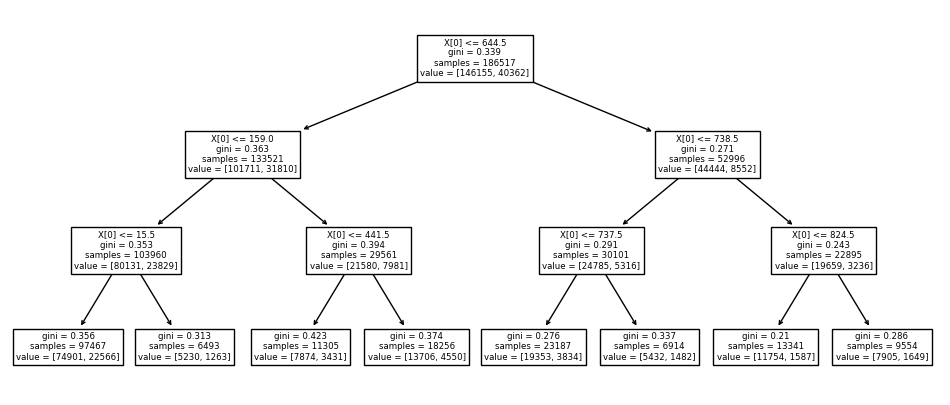

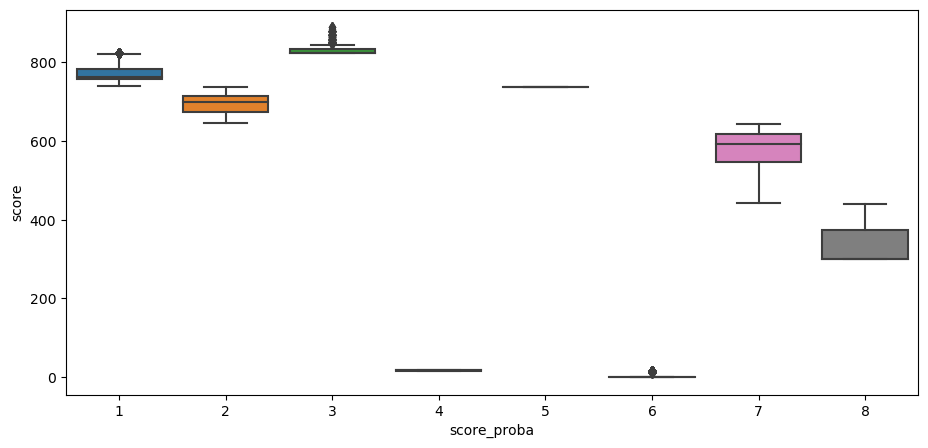

In [34]:
# prosseguindo com a análise de 'score'

tree_thresholds(df, 'score', 'default', 3)
proba_box(df, 'score', 'default', 3)

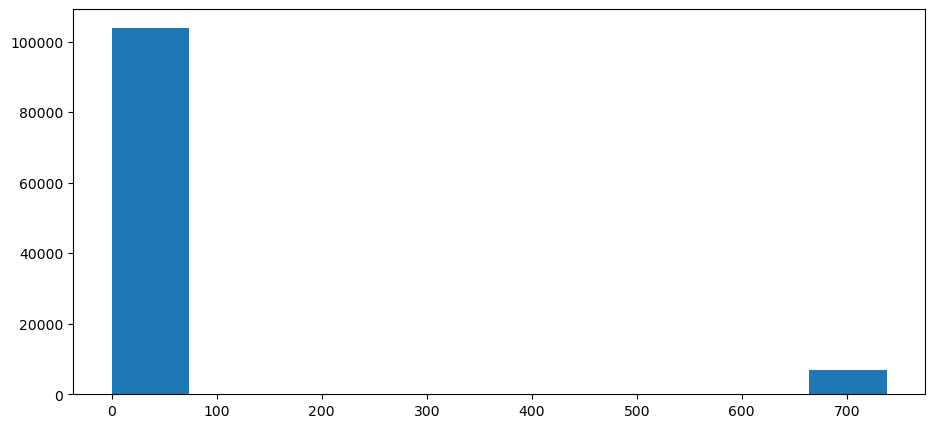

In [35]:
# resultado curioso, a expectativa era de que esta variável trouxesse muita informação sobre o alvo

# o que aconteceu em 4, 5, 6?

plt.hist(df.loc[df['score_proba'].isin([4, 5, 6]), 'score'])
plt.show()

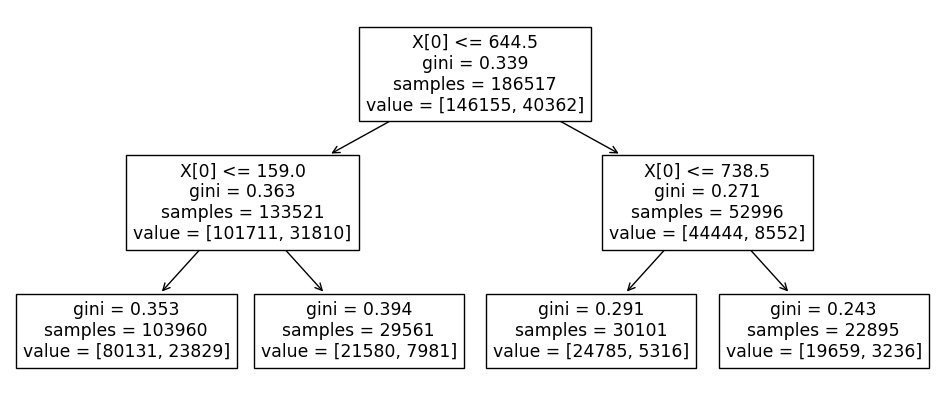

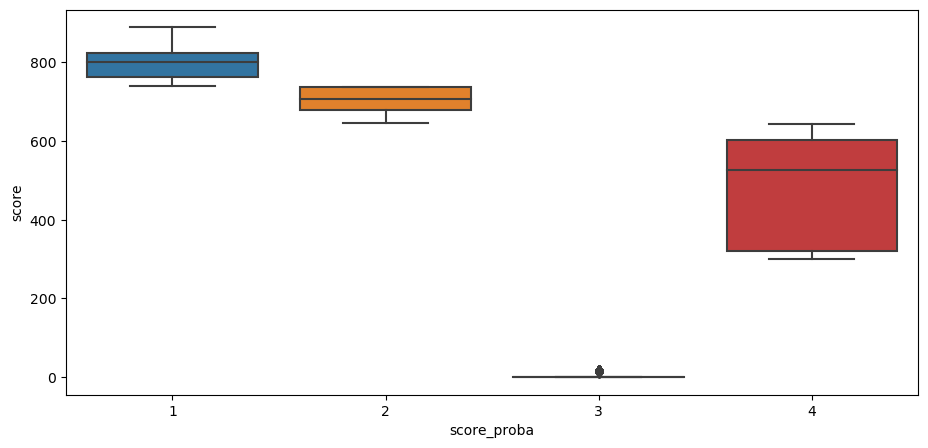

In [36]:
# testando número menor de bins
tree_thresholds(df, 'score', 'default', 2)
proba_box(df, 'score', 'default', 2)

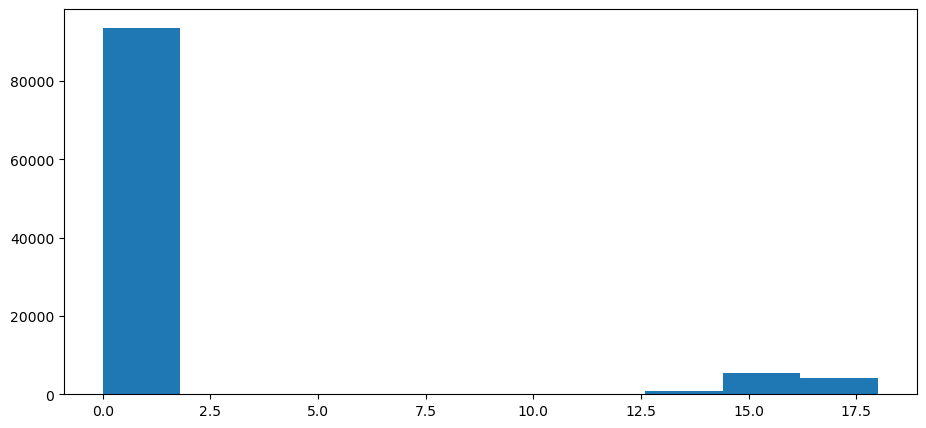

In [37]:
# o que aconteceu em 3?
plt.hist(df.loc[df['score_proba'] == 3, 'score'])
plt.show()

In [38]:
# o grande número de scores iguais a 0 tornam a variável score menos confiável, 
# para contornar este problema, podemos alocar este grupo de dados sob a categoria 0, antes de passar os
# dados no modelo

# como ficariam os dados de 'score', sem o grande volume de zeros ?

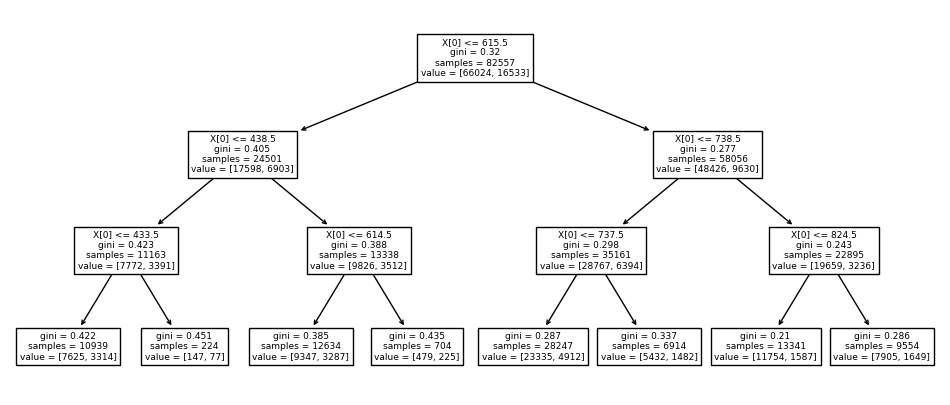

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


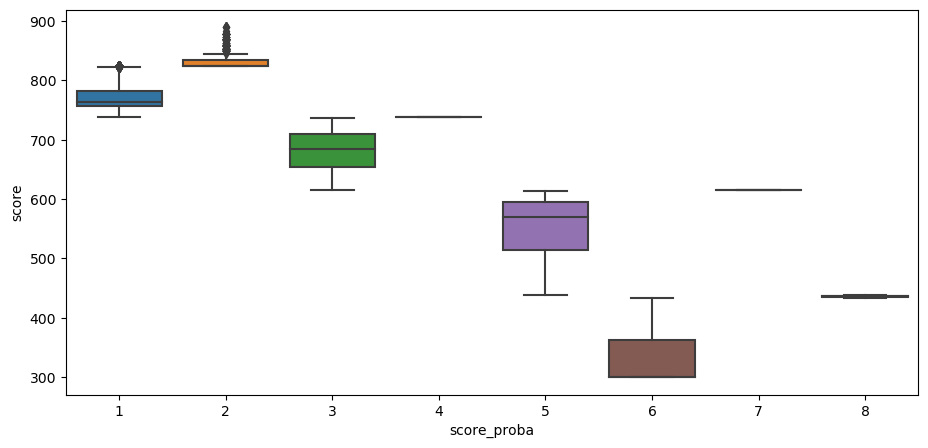

In [39]:
aux = df.loc[df['score'] > 20]
tree_thresholds(aux, 'score', 'default', 3)
proba_box(aux, 'score', 'default', 3)

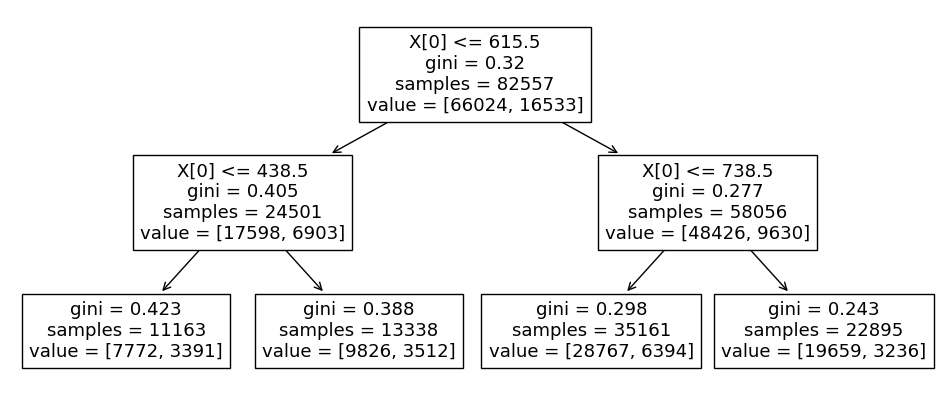

c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\fkhon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


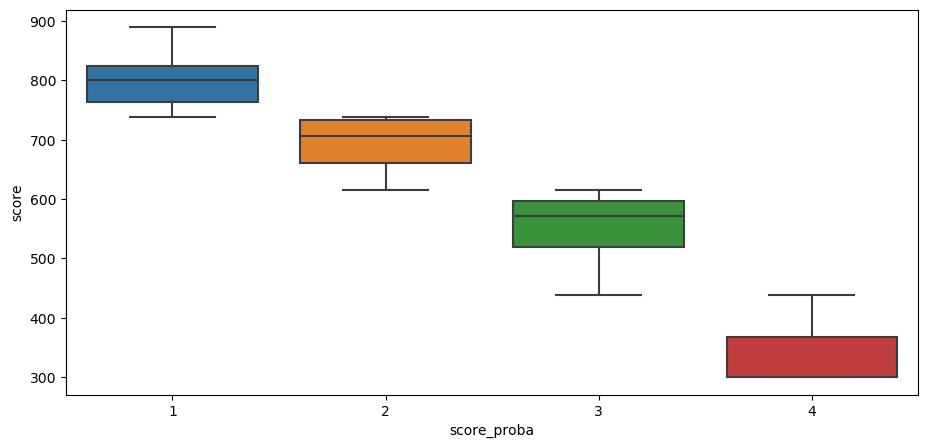

In [40]:
tree_thresholds(aux, 'score', 'default', 2)
proba_box(aux, 'score', 'default', 2)

In [41]:
# notamos que com 8 bins, a variável continua inconsistente, mas com 4, ela passa a ser útil, após lidarmos
# com os zeros